In [1]:
# Imports
from os import makedirs
import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse
from rdkit.Chem.AllChem import MolFromSmiles, MolToSmiles
from IPython.display import display
from matplotlib import pyplot as plt

In [17]:
# Save each chosen cell-line into 2 CSV files. One with z-score, one with thresholded z-score

OUT_DIR = f"out/th_multi_label/"

# Create the dirs
zscore_dir = f"{OUT_DIR}zscore-highestactivity/"
makedirs(zscore_dir, exist_ok=True)
class_dir = f"{OUT_DIR}classification-highestactivity/"
makedirs(class_dir, exist_ok=True)
class_dir2 = f"{OUT_DIR}classification-filtered/"
makedirs(class_dir2, exist_ok=True)

modified_final_df = {}
data_cols2 = ["geneID-" + str(col) for col in data_cols]
data_cols_rename = {data_cols[ii]: data_cols2[ii] for ii in range(len(data_cols))}
for line, this_df in df_per_cell_line_cleaned.items():
    this_df = this_df.rename(columns=data_cols_rename)
    this_df.to_csv(f"{zscore_dir}{line}.csv", index=False)
    this_df_classification = this_df.copy(deep=True)
    this_df_classification[data_cols2] = this_df_classification[data_cols2].applymap(apply_labels)
    this_df_classification.to_csv(f"{class_dir}{line}.csv", index=False)
    # display(this_df_classification)
    modified_final_df[line] = this_df_classification
    remove_cols = [col for col in data_cols2 if np.sum(this_df_classification[col] != 2) < MIN_ACTIVE_PER_COL]
    print("removed columns", remove_cols)
    print("len of removed cols", len(remove_cols))
    this_df_class_filtered = this_df_classification.copy(deep=True).drop(columns=remove_cols)
    this_df_class_filtered.to_csv(f"{class_dir2}{line}.csv", index=False)
    vals = this_df_class_filtered[set(data_cols2) - set(remove_cols)].values
    print("{}:\tnum mols: {}; \tnum cols removed = {}; \tnum of 0's = {}; \tnum of 1's = {}; \tnum of 2's = {}; \tnum of 3's = {}; \tnum of 4's = {}\n".format(
    line, vals.shape[0], len(remove_cols),np.unique(vals,return_counts=True)[1][0],np.unique(vals,return_counts=True)[1][1],np.unique(vals,return_counts=True)[1][2],np.unique(vals,return_counts=True)[1][3],np.unique(vals,return_counts=True)[1][4])
    )

U2OS:	num mols: 16058; 	num cols removed = 0; 	density of positives = 199.91%

HA1E:	num mols: 5514; 	num cols removed = 0; 	density of positives = 199.56%

VCAP:	num mols: 15220; 	num cols removed = 0; 	density of positives = 199.47%

A549:	num mols: 12285; 	num cols removed = 0; 	density of positives = 199.44%

MCF7:	num mols: 11622; 	num cols removed = 0; 	density of positives = 199.45%

PC3:	num mols: 11521; 	num cols removed = 0; 	density of positives = 199.53%

A375:	num mols: 10694; 	num cols removed = 0; 	density of positives = 199.66%



In [26]:
for line, this_df in modified_final_df.items():
    print(line)
    print("shape of datafarme with duplicates:" , this_df.shape)
    modified_final_df[line] = this_df.drop_duplicates(subset='SMILES', keep="first")
    print("shape of datafarme sfter removing duplicates:" , modified_final_df[line].shape)
    print("-------------------------------")


U2OS
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (16057, 984)
-------------------------------
HA1E
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (5488, 984)
-------------------------------
VCAP
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (15193, 984)
-------------------------------
A549
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (12256, 984)
-------------------------------
MCF7
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (11585, 984)
-------------------------------
PC3
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (11485, 984)
-------------------------------
A375
shape of datafarme with duplicates: (16058, 984)
shape of datafarme sfter removing duplicates: (10680, 984)
-------------------

In [27]:
import functools as ft
dfs = [this_df for line, this_df in modified_final_df.items()]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='SMILES'), dfs)
common_smiles = df_final['SMILES']
print(len(common_smiles))

1450


In [28]:
lst_numbers = []
for check_df in dfs: 
    modified_1  = check_df.loc[check_df['SMILES'].isin(common_smiles)]
    numbers = modified_1[data_cols2]
    values_gene_id = np.reshape(numbers.values, (1,numbers.shape[0]*numbers.shape[1]))
    lst_numbers.append(values_gene_id)
df_corr = pd.DataFrame(np.concatenate(lst_numbers))
df_corr

,0,1,2,3,4,5,6,7,8,9,...,1418090,1418091,1418092,1418093,1418094,1418095,1418096,1418097,1418098,1418099
0,2,2,2,2,2,2,2,2,2,2,...,3,4,2,0,1,0,1,0,0,2
1,2,2,2,2,2,2,2,2,2,2,...,3,2,2,2,0,0,2,1,0,2
2,2,2,2,2,2,2,2,2,2,2,...,0,2,2,4,2,2,2,2,1,2
3,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,1,0,3,0,0,2
4,2,2,2,2,2,2,2,2,2,2,...,2,3,2,0,2,1,4,3,2,4
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,1,0,0,2,2,2,3
6,2,2,2,2,2,2,2,2,2,2,...,2,0,1,1,2,0,3,3,2,2


In [29]:
df_transpose = df_corr.transpose()
df_transpose.columns = df_transpose.columns.astype(str)
df_transpose = df_transpose.rename(columns={'0': 'U2OS', '1': 'HA1E','2': 'VCAP', '3': 'A549','4': 'MCF7', '5': 'PC3','6': 'A375' })
df_transpose.columns
corr_values = df_transpose.corr()
corr_values

,0,1,2,3,4,5,6
0,1.000000,0.060399,0.061331,0.042867,0.060538,0.062246,0.061650
1,0.060399,1.000000,0.079837,0.083084,0.082264,0.097515,0.102486
2,0.061331,0.079837,1.000000,0.090002,0.090035,0.092994,0.099552
3,0.042867,0.083084,0.090002,1.000000,0.079212,0.100671,0.104961
4,0.060538,0.082264,0.090035,0.079212,1.000000,0.090312,0.086981
5,0.062246,0.097515,0.092994,0.100671,0.090312,1.000000,0.115805
6,0.061650,0.102486,0.099552,0.104961,0.086981,0.115805,1.000000


<Axes: >

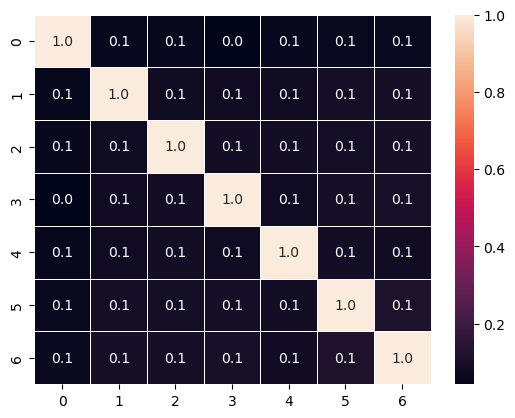

In [37]:
import seaborn as sns
sns.heatmap(corr_values, annot= True,linewidth=.5, fmt=".4f")